In [ ]:
# Jean Allen // University of California, Santa Barbara
# 2024-07-15
# total runtime ~2.5 minutes

In [12]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import os

import numpy as np
import pandas as pd

from isofit.core.common import (
    get_refractive_index,
)

from isofit.inversion.inverse_simple import invert_liquid_water

## 1. Setting Up

In [11]:
# wavelength bounds to use for the liquid water calculation
left_bound = 1100
right_bound = 1300

spectra_folder = 'C:/Users/jeanallen/Desktop/SHIFT_CWC/data/SHIFT_data/extracted_spectra_by_tree'
output_dir = 'C:/Users/jeanallen/Desktop/SHIFT_CWC/data/SHIFT_data/cwc_' + str(left_bound) + '_' + str(right_bound) 

make_figures = False
figure_dir = None

In [13]:
if make_figures and not os.path.exists(figure_dir):
    os.makedirs(figure_dir)

In [14]:
# load up the target spectra
date_list = ['20220224', '20220228',  '20220308', '20220316', '20220322', '20220405', '20220420', '20220429', '20220503', '20220511', '20220517', '20220529', '20220914']
file_list = [os.path.join(spectra_folder, f'{date}_tree_spectra.csv') for date in date_list]

# load up water absorption data
isofit_path = 'C:/Users/jeanallen/MiniConda3/envs/rs/Lib/site-packages'  ## may vary for other users
path_k = os.path.join(isofit_path, "data", "iop", "k_liquid_water_ice.xlsx")
k_wi = pd.read_excel(io=path_k, sheet_name="Sheet1", engine="openpyxl")

# make output directory if it doesn't exist
if not os.path.exists(output_dir):
    print(f'Creating output directory {output_dir}')
    os.makedirs(output_dir)

Creating output directory C:/Users/jeanallen/Desktop/SHIFT_CWC/data/SHIFT_data/cwc_1100_1300


## 2. Testing...

In [15]:
## function for beer lambert propagation; largely ripped from isofit but lightly edited to fit our needs
def beer_lambert_propagation(wl, alpha_lw, cwc, intercept, slope):
    # wl: wavelengths
    # alpha_lw: liquid water absorption coefficient
    # cwc: canopy water content returned by invert_liquid_water
    # intercept: intercept of the linear fit returned by invert_liquid_water
    # slope: slope of the linear fit returned by invert_liquid_water
    
    attenuation = np.exp(-cwc * 1e7 * alpha_lw)
    return (intercept + slope * wl) * attenuation

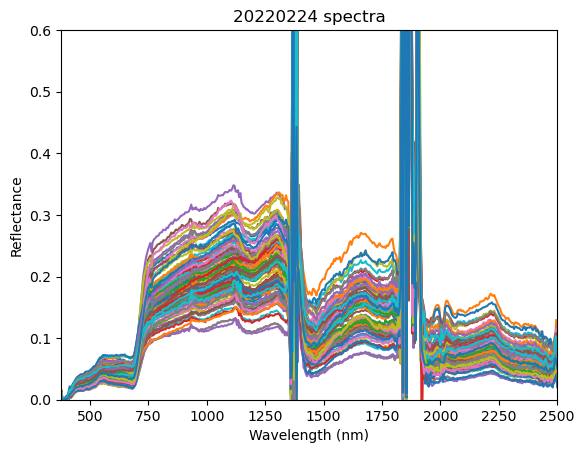

In [16]:
date = date_list[0]
file = file_list[0]
spectra = pd.read_csv(file).rename(columns={'Unnamed: 0': 'Wavelength (nm)'}).set_index('Wavelength (nm)')
spectra.plot(legend=False)
plt.title(f'{date} spectra')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.xlim(spectra.index.min(), spectra.index.max())
plt.ylim(0, 0.6)
plt.show()

In [17]:
# get index of bounds for cwc calculation
left_idx = np.argmin(np.abs(spectra.index - left_bound))
right_idx = np.argmin(np.abs(spectra.index - right_bound))
print(f'Left index: {left_idx}, Right index: {right_idx}')

Left index: 144, Right index: 184


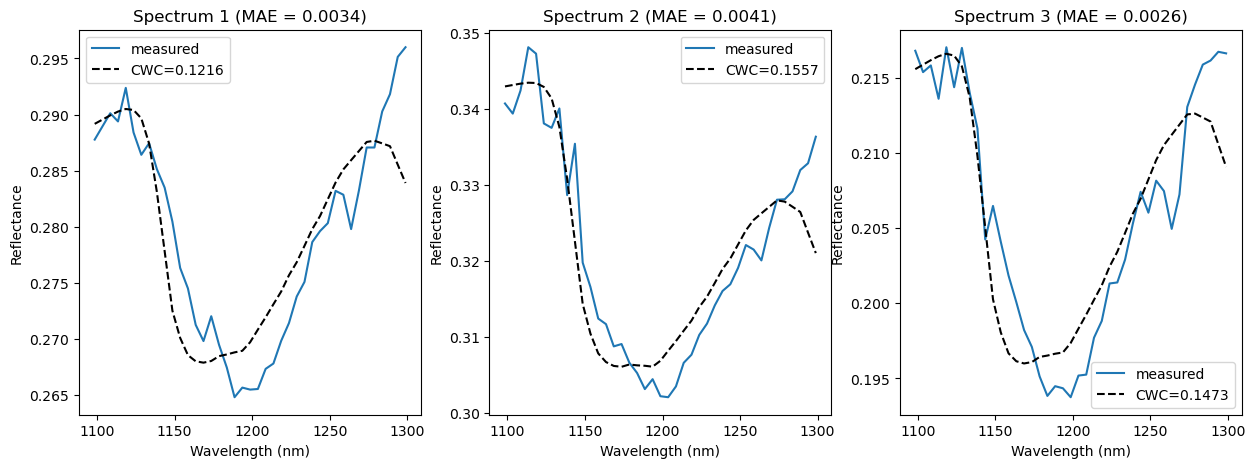

In [18]:
## plot CWC retrieval for a few selected spectra...
wl = spectra.index.to_numpy()

rfl1 = spectra.iloc[:,0].to_numpy()
rfl2 = spectra.iloc[:,4].to_numpy()
rfl3 = spectra.iloc[:,7].to_numpy()

cwc1, intercept1, slope1 = invert_liquid_water(rfl1, wl, l_shoulder=left_bound, r_shoulder=right_bound)
cwc2, intercept2, slope2 = invert_liquid_water(rfl2, wl, l_shoulder=left_bound, r_shoulder=right_bound)
cwc3, intercept3, slope3 = invert_liquid_water(rfl3, wl, l_shoulder=left_bound, r_shoulder=right_bound)

wl_water, k_water = get_refractive_index(k_wi=k_wi, a=0, b=982, col_wvl="wvl_6", col_k="T = 20°C")
kw = np.interp(x=wl, xp=wl_water, fp=k_water)
abs_co_w = 4 * np.pi * kw / wl
alpha_lw = abs_co_w
beer_lambert1 = beer_lambert_propagation(wl, alpha_lw, cwc1, intercept1, slope1)
mean_abs_error1 = np.mean(np.abs(rfl1[left_idx:right_idx+1] - beer_lambert1[left_idx:right_idx+1]))
beer_lambert2 = beer_lambert_propagation(wl, alpha_lw, cwc2, intercept2, slope2)
mean_abs_error2 = np.mean(np.abs(rfl2[left_idx:right_idx+1] - beer_lambert2[left_idx:right_idx+1]))
beer_lambert3 = beer_lambert_propagation(wl, alpha_lw, cwc3, intercept3, slope3)
mean_abs_error3 = np.mean(np.abs(rfl3[left_idx:right_idx+1] - beer_lambert3[left_idx:right_idx+1]))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.plot(wl[left_idx:right_idx+1], rfl1[left_idx:right_idx+1], label='measured')
ax1.plot(wl[left_idx:right_idx+1], beer_lambert1[left_idx:right_idx+1], label='CWC='+str(round(cwc1,4)), linestyle='--', color='black')
ax1.set_title('Spectrum 1 (MAE = '+str(round(mean_abs_error1,4))+')')
ax1.set_xlabel('Wavelength (nm)')
ax1.set_ylabel('Reflectance')
ax1.legend()

ax2.plot(wl[left_idx:right_idx+1], rfl2[left_idx:right_idx+1], label='measured')
ax2.plot(wl[left_idx:right_idx+1], beer_lambert2[left_idx:right_idx+1], label='CWC='+str(round(cwc2,4)), linestyle='--', color='black')
ax2.set_title('Spectrum 2 (MAE = '+str(round(mean_abs_error2,4))+')')
ax2.set_xlabel('Wavelength (nm)')
ax2.set_ylabel('Reflectance')
ax2.legend()

ax3.plot(wl[left_idx:right_idx+1], rfl3[left_idx:right_idx+1], label='measured')
ax3.plot(wl[left_idx:right_idx+1], beer_lambert3[left_idx:right_idx+1], label='CWC='+str(round(cwc3,4)), linestyle='--', color='black')
ax3.set_title('Spectrum 3 (MAE = '+str(round(mean_abs_error3,4))+')')
ax3.set_xlabel('Wavelength (nm)')
ax3.set_ylabel('Reflectance')
ax3.legend()

plt.show()

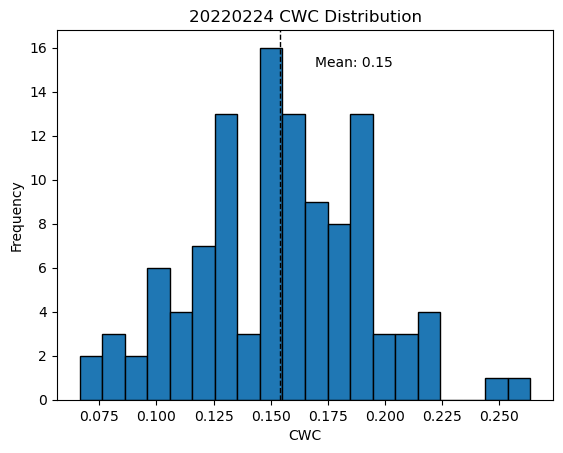

In [19]:
# now try calculating CWC for all trees for a single date
wl = spectra.index.to_numpy()
output_cwc = []

for treenum,spec in spectra.iteritems():
    rfl_meas = spec.values
    cwc, intercept, slope = invert_liquid_water(rfl_meas, wl, l_shoulder=left_bound, r_shoulder=right_bound)


    wl_water, k_water = get_refractive_index(k_wi=k_wi, a=0, b=982, col_wvl="wvl_6", col_k="T = 20°C")
    kw = np.interp(x=wl, xp=wl_water, fp=k_water)
    abs_co_w = 4 * np.pi * kw / wl
    alpha_lw = abs_co_w
    beer_lambert = beer_lambert_propagation(wl, alpha_lw, cwc, intercept, slope)
    mae = np.mean(np.abs(rfl_meas[left_idx:right_idx+1] - beer_lambert[left_idx:right_idx+1]))

    output_cwc.append([treenum, cwc, intercept, slope, mae])

    # # plot each retrieval for posterity
    # gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1.2])
    # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={'width_ratios': [1,1.5]})
    # ax1.plot(wl[left_idx:right_idx+1], rfl_meas[left_idx:right_idx+1], label='measured')
    # ax1.plot(wl[left_idx:right_idx+1], beer_lambert[left_idx:right_idx+1], label='CWC='+str(round(cwc1,4)), linestyle='--', color='black')
    # ax1.set_title('CWC fit region (RMSE = '+str(round(mae,4))+')')
    # ax1.set_xlabel('Wavelength (nm)')
    # ax1.set_ylabel('Reflectance')
    # ax1.legend()
    # wl_nan = rfl_meas.copy()
    # wl_nan[wl < 400] = np.nan 
    # wl_nan[wl > 2475] = np.nan 
    # wl_nan[np.logical_and(wl > 1350, wl < 1480)] = np.nan 
    # wl_nan[np.logical_and(wl > 1800, wl < 1950)] = np.nan 
    # ax2.plot(wl, wl_nan, label='measured')
    # ax2.set_title('Full Spectrum')
    # ax2.set_xlabel('Wavelength (nm)')
    # ax2.set_ylabel('Reflectance')
    # ax2.set_xlim(400, 2475)
    # plt.tight_layout()
    # # plt.show()
    # plt.close()


output_cwc_df = pd.DataFrame(output_cwc, columns=['Tree Number', 'CWC', 'Intercept', 'Slope', 'RMSE'])

# make histogram of CWC values
plt.hist(output_cwc_df['CWC'], bins=20, edgecolor='black')
plt.xlabel('CWC')
plt.ylabel('Frequency')
plt.title(date + ' CWC Distribution')
plt.axvline(output_cwc_df['CWC'].mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(output_cwc_df['CWC'].mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(output_cwc_df['CWC'].mean()))
plt.show()

## 3. Calculate CWC for all dates for all trees

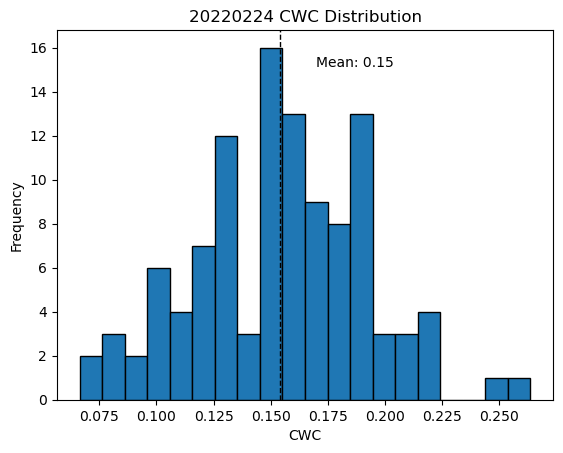

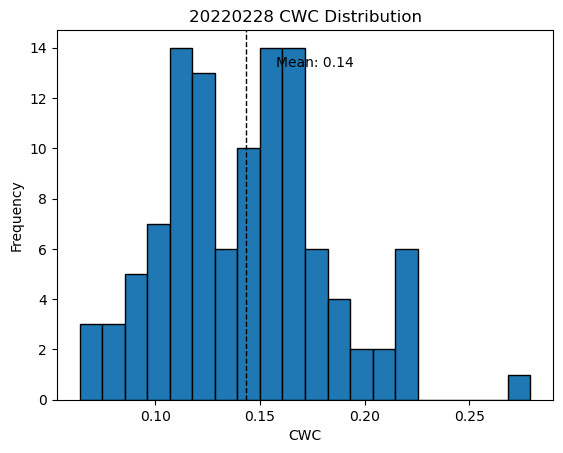

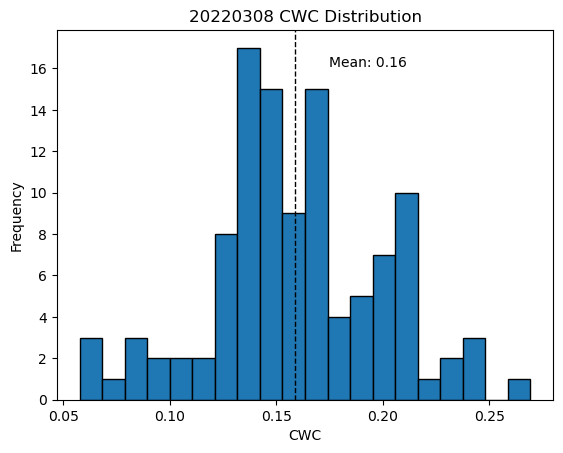

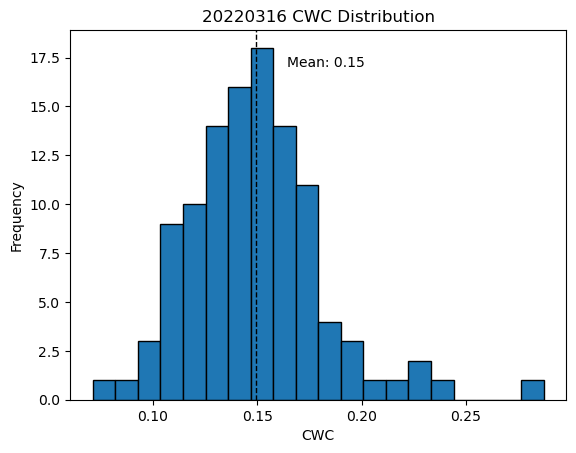

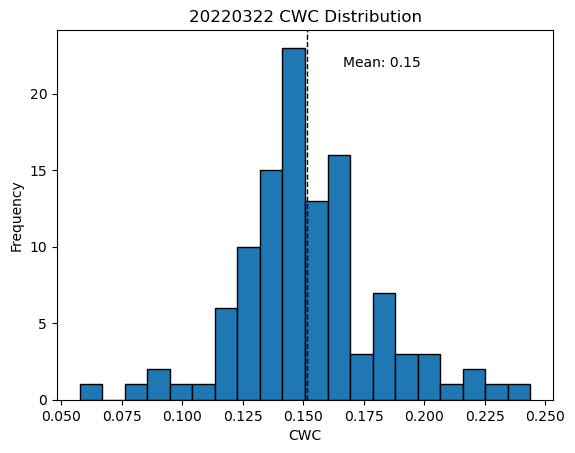

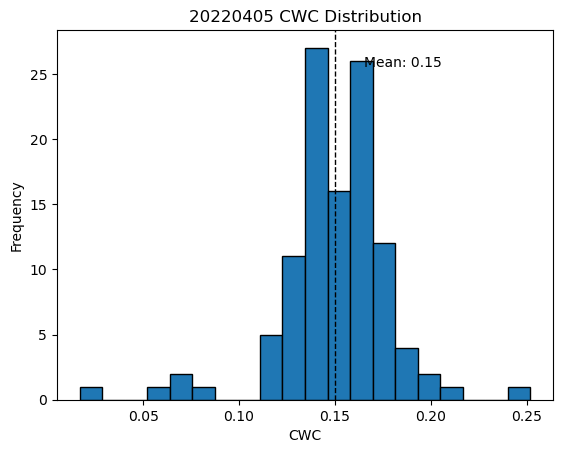

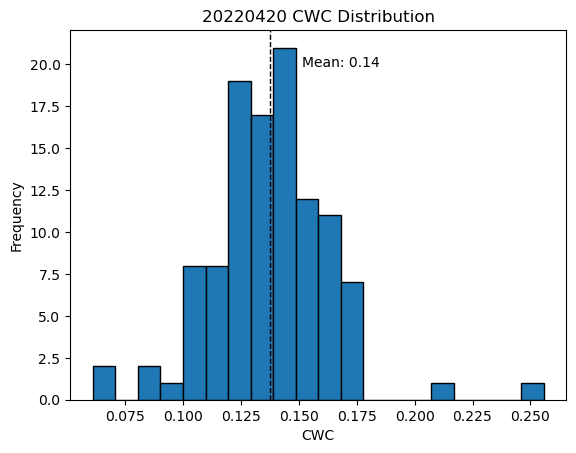

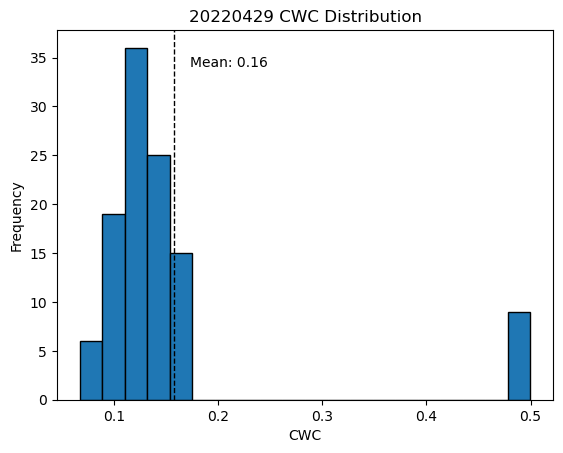

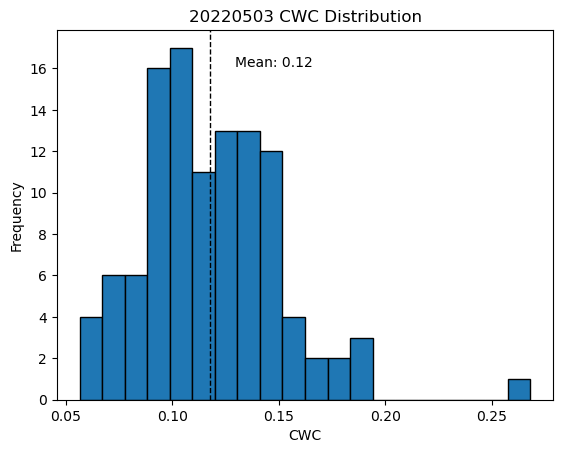

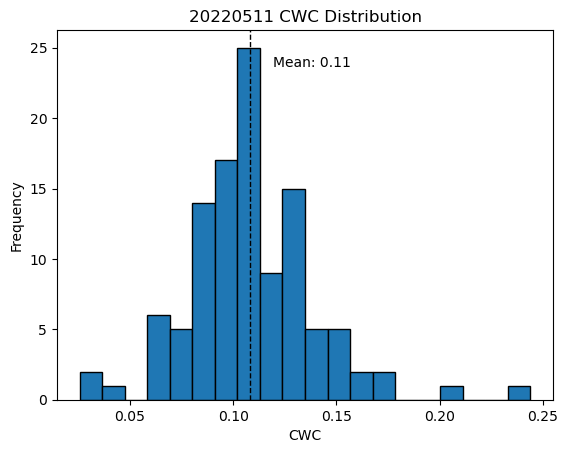

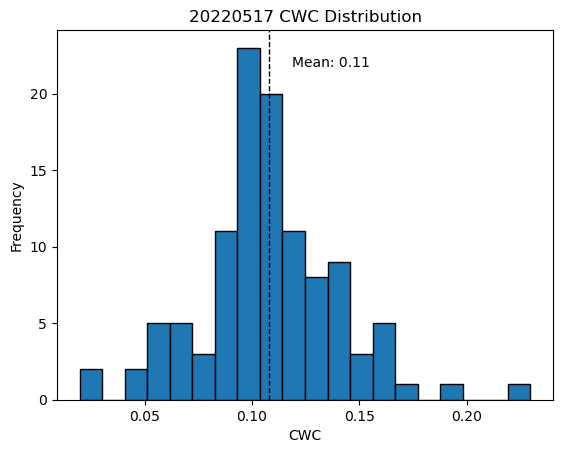

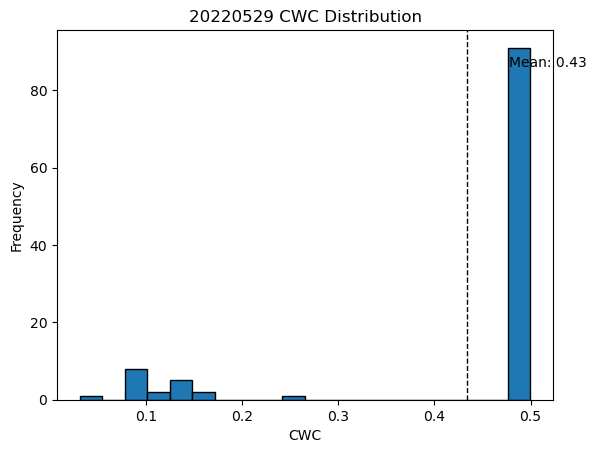

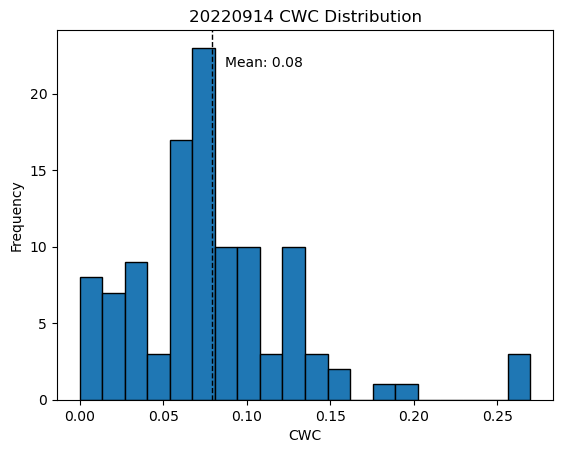

In [20]:
# this runs super slow because of the dataframe iteration
# and because we load up the water absorption data for every tree
# oh well
for date,file in zip(date_list,file_list):

    df = pd.read_csv(file).rename(columns={'Unnamed: 0': 'Wavelength (nm)'}).set_index('Wavelength (nm)')
    wl = df.index.to_numpy()
    output_cwc = []

    for treenum,spec in df.iteritems():
        if treenum == '2337?':  # handling for one bad field data label (whoops)
            continue

        rfl_meas = spec.values
        cwc, intercept, slope = invert_liquid_water(rfl_meas, wl, l_shoulder=left_bound, r_shoulder=right_bound)

        wl_water, k_water = get_refractive_index(k_wi=k_wi, a=0, b=982, col_wvl="wvl_6", col_k="T = 20°C")
        kw = np.interp(x=wl, xp=wl_water, fp=k_water)
        abs_co_w = 4 * np.pi * kw / wl
        alpha_lw = abs_co_w
        beer_lambert = beer_lambert_propagation(wl, alpha_lw, cwc, intercept, slope)
        mae = np.mean(np.abs(rfl_meas[left_idx:right_idx+1] - beer_lambert[left_idx:right_idx+1]))

        output_cwc.append([treenum, cwc, intercept, slope, mae])

        if make_figures:
            if not os.path.exists(os.path.join(figure_dir, date)):
                os.makedirs(os.path.join(figure_dir, date))
            gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1.2])
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={'width_ratios': [1,1.5]})
            ax1.plot(wl[95:150], rfl_meas[95:150], label='measured')
            ax1.plot(wl[95:150], beer_lambert[95:150], label='CWC='+str(round(cwc,4)), linestyle='--', color='black')
            ax1.set_title('CWC fit region (MAE = '+str(round(mae,4))+')')
            ax1.set_xlabel('Wavelength (nm)')
            ax1.set_ylabel('Reflectance')
            ax1.legend()
            wl_nan = rfl_meas.copy()
            wl_nan[wl < 400] = np.nan 
            wl_nan[wl > 2475] = np.nan 
            wl_nan[np.logical_and(wl > 1350, wl < 1480)] = np.nan 
            wl_nan[np.logical_and(wl > 1800, wl < 1950)] = np.nan 
            ax2.plot(wl, wl_nan)
            ax2.set_title('Tree #' + treenum + ', ' + date + ' -- Full Spectrum')
            ax2.set_xlabel('Wavelength (nm)')
            ax2.set_ylabel('Reflectance')
            ax2.set_xlim(400, 2475)
            plt.tight_layout()
            plt.savefig(os.path.join(figure_dir, date, treenum+'.png'))
            plt.close()

    output_cwc = pd.DataFrame(output_cwc, columns=['Tree Number', 'CWC', 'Intercept', 'Slope', 'MAE'])
    output_cwc.to_csv(os.path.join(output_dir, date+'_cwc.csv'), index=False)

    # make histogram of CWC values
    plt.hist(output_cwc['CWC'], bins=20, edgecolor='black')
    plt.xlabel('CWC')
    plt.ylabel('Frequency')
    plt.title(date + ' CWC Distribution')
    plt.axvline(output_cwc['CWC'].mean(), color='k', linestyle='dashed', linewidth=1)
    min_ylim, max_ylim = plt.ylim()
    plt.text(output_cwc['CWC'].mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(output_cwc['CWC'].mean()))
    plt.show()
    plt.close()